In [45]:
import random

def bits(x):
    """
    Generate a stochastic number of the specified length with the given probability of having a '1' bit.
    """
    return 1 if random.random() < x else 0

def XOR(inputs):
    return sum(inputs) % 2 == 1
def NOR(inputs):
    return not any(inputs)
def NAND(inputs):
    return not all(inputs)
def OR(inputs):
    return any(inputs)
def AND(inputs):
    return all(inputs)
def NOT(input):
    return not input
def MUX2x1(input0, input1, control):
    # When control is 0, select input0; when control is 1, select input1
    # You can use bitwise operations to perform the selection
    selected_input0 = (input0 & ~control)  # input0 when control is 0
    selected_input1 = (input1 & control)   # input1 when control is 1
    
    # Combine the selected inputs using bitwise OR
    output = selected_input0 | selected_input1
    
    return output

x = 0.5
y = 0.5

N = 32
r1 = 0
r2 = 0
for i in range(N):
    r1 += AND([bits(x), bits(y)])
    r2 += MUX2x1(bits(x), bits(y), bits(0.5))

print(r1/N, r2/N)

0.21875 0.3125


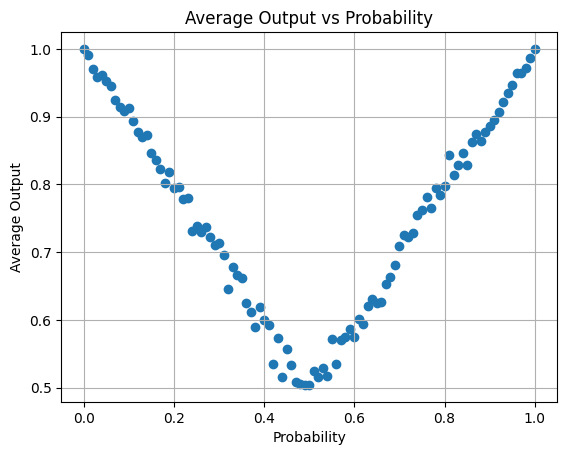

In [77]:
import random
import matplotlib.pyplot as plt

class BinaryCounter:
    def __init__(self, depth):
        self.depth = depth
        self.cnt = [0] * (depth + 1)

    def reset(self):
        self.cnt = [0] * self.depth + [1]

    def update(self, input):
        if input:
            for i in range(self.depth + 1):
                if not self.cnt[i]:
                    self.cnt[i] = 1
                    break
        else:
            for i in range(self.depth + 1):
                if self.cnt[i]:
                    self.cnt[i] = 0
                    break

    def output_tanh(self):
        return int(self.cnt[self.depth] == 1)
    
    def output_abs(self):
        if self.cnt[self.depth] == 0:
            y = self.cnt[0] == 0
        else:
            y = self.cnt[0] == 1
        return int(y)

def generate_stochastic_bitstream(N, p):
    bitstream = [random.random() < p for _ in range(N)]
    return bitstream

def simulate_counter(bitstream, counter):
    results = []
    for bit in bitstream:
        counter.update(bit)
        results.append(counter.output_abs())
    return sum(results) / len(results)


N = 1024
counter_depth = 8
counter = BinaryCounter(counter_depth)

probabilities = [i / 100 for i in range(101)]
average_outputs = []

for p in probabilities:
    counter.reset()
    bitstream = generate_stochastic_bitstream(N, p)
    average_output = simulate_counter(bitstream, counter)
    average_outputs.append(average_output)

# Plot the results
plt.scatter(probabilities, average_outputs)
plt.xlabel('Probability')
plt.ylabel('Average Output')
plt.title('Average Output vs Probability')
plt.grid(True)
plt.show()



In [256]:
import random

def monte_carlo_pi(num_samples):
    inside_circle = 0

    for _ in range(num_samples):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)

        # Check if the point (x, y) is inside the unit circle
        if x**2 + y**2 <= 1:
            inside_circle += 1

    # Estimate π using the Monte Carlo method
    pi_estimate = 4 * inside_circle / num_samples
    return pi_estimate

if __name__ == "__main__":
    num_samples = 10000
    estimated_pi = monte_carlo_pi(num_samples)
    print(f"Estimated value of π using {num_samples} samples: {estimated_pi}")

Estimated value of π using 10000 samples: 3.1224


In [282]:
def monte_carlo_pi(num_samples, N):
    inside_circle = 0

    for _ in range(num_samples):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        val = 0
        for n in range(N):
            val += MUX2x1(AND([random.random()>x,random.random()>x]), AND([random.random()>y,random.random()>y]), random.random()>0.5)
        # Check if the point (x, y) is inside the unit circle
        if val/N <= 0.5:
            inside_circle += 1

    # Estimate π using the Monte Carlo method
    pi_estimate = 4 * inside_circle / (num_samples)
    return pi_estimate

if __name__ == "__main__":
    num_samples = 10000
    estimated_pi = monte_carlo_pi(num_samples, 16)
    print(f"Estimated value of π using {num_samples} samples: {estimated_pi}")

Estimated value of π using 10000 samples: 3.16


Episode 500000/500000.

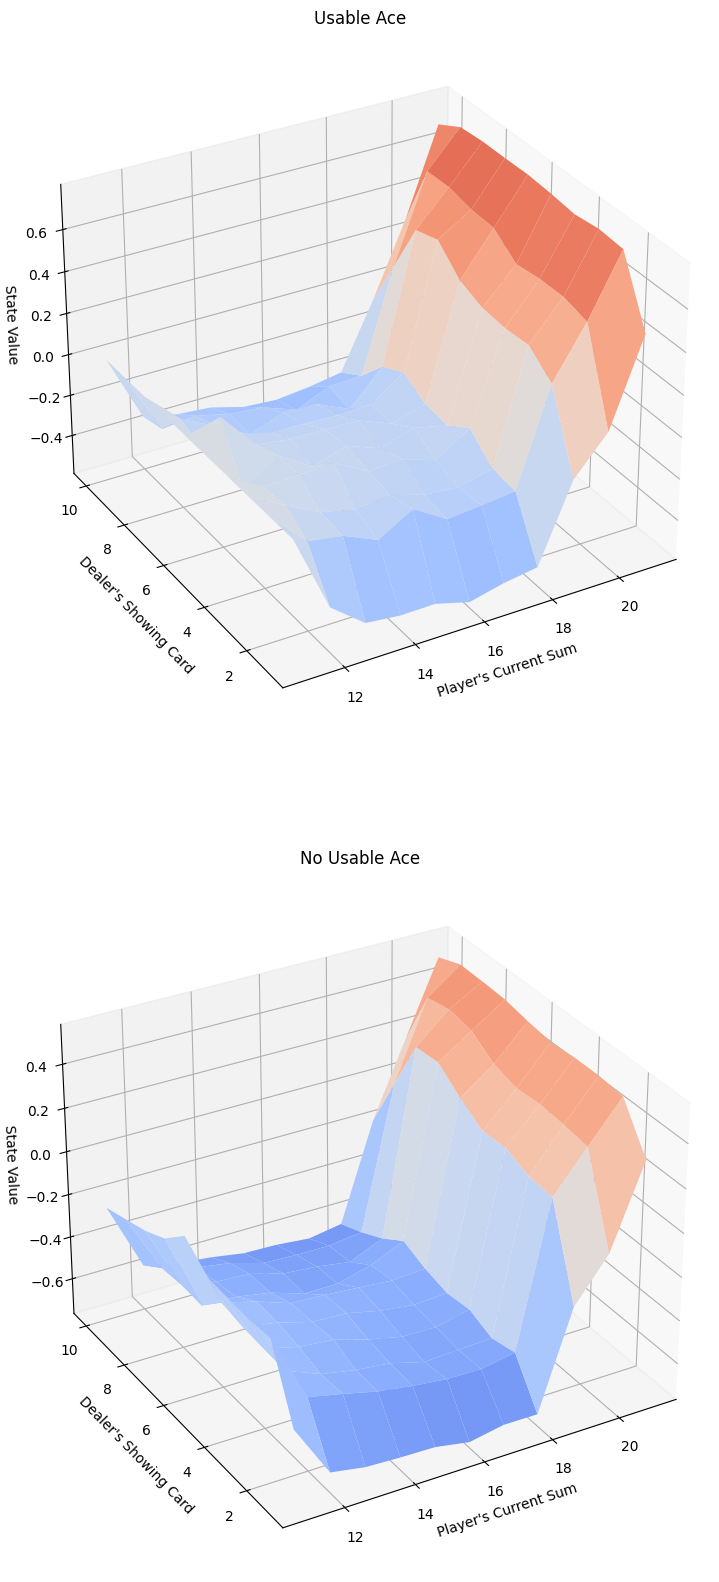

In [281]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

env = gym.make('Blackjack-v1')

def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()[0]
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, unknown, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode


def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q


# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)